### 1.Problem Statement : Create a model to predict the drugs type.

In [1]:
#pip install mixed_naive_bayes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import scipy.stats as ss
from sklearn.preprocessing import FunctionTransformer,PowerTransformer
from sklearn.preprocessing import LabelEncoder
from mixed_naive_bayes import MixedNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.compose import ColumnTransformer
import pickle

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

### 2.Data Collection

In [3]:
data=pd.read_csv(r"C:\Users\khang\Elite 14 M-L\ML_Project\raw Data\drug200 (1).csv")

In [4]:
df=data.copy()

In [5]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


### 3.EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [7]:
df.shape # No missing values

(200, 6)

In [8]:
df.duplicated().sum() # No duplicates

0

In [9]:
df["Drug"].value_counts() # data is heavily Imbalanced 

DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

In [10]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [11]:
df["Sex"]=df["Sex"].astype("category")

### 4.Data Preprocessing

In [12]:
fv=df.iloc[:,0:5]
cv=df.iloc[:,5]

In [13]:
fv.head()

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043


In [14]:
cv.head()

0    DrugY
1    drugC
2    drugC
3    drugX
4    DrugY
Name: Drug, dtype: object

### 5.EDA after preprocessing

In [15]:
df.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [16]:
#splitting the data into train and test
x_train,x_test,y_train,y_test=train_test_split(fv,cv,test_size=0.2,random_state=3,stratify=cv)

In [17]:
# concatinating x_train and y_train to perform EDA in order to know more about these features

df_eda=pd.concat([x_train,y_train],axis=1)
df_eda

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
45,66,F,NORMAL,NORMAL,8.107,drugX
162,43,M,NORMAL,NORMAL,12.859,drugX
62,67,M,LOW,NORMAL,20.693,DrugY
177,25,M,NORMAL,HIGH,19.011,DrugY
61,24,M,HIGH,NORMAL,9.475,drugA
...,...,...,...,...,...,...
126,66,M,HIGH,HIGH,16.347,DrugY
134,42,F,HIGH,HIGH,21.036,DrugY
188,65,M,HIGH,NORMAL,34.997,DrugY
26,31,M,HIGH,HIGH,30.366,DrugY


In [18]:
df_eda["Sex"].value_counts()

M    87
F    73
Name: Sex, dtype: int64

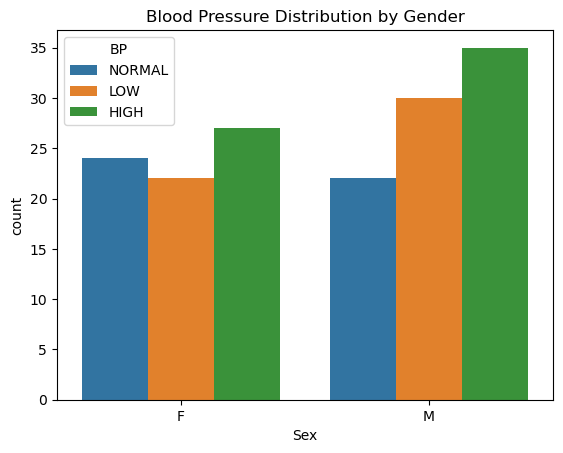

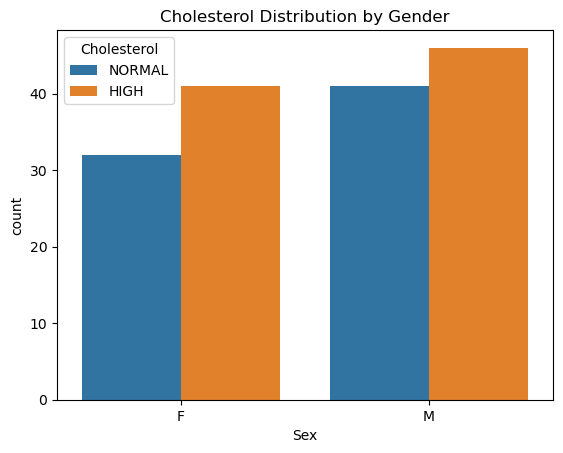

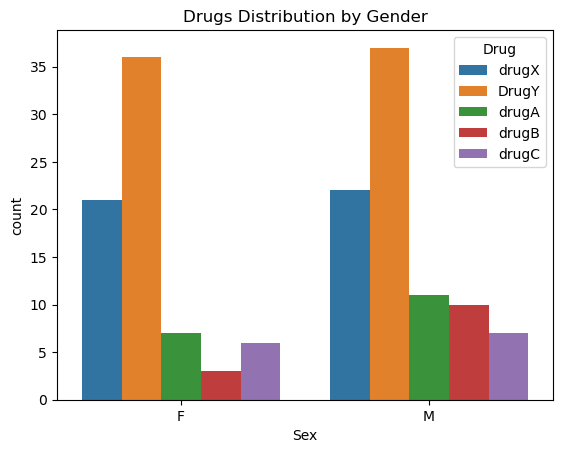

In [22]:
#  the count of males and females who are having low, high and normal BP
sns.countplot(x="Sex",data=df_eda,hue="BP")
plt.title("Blood Pressure Distribution by Gender")
plt.show()


#  the count of males and females who are having high and normal cholesterol
sns.countplot(x="Sex",data=df_eda,hue="Cholesterol")
plt.title("Cholesterol Distribution by Gender")
plt.show()


# the no. of males and females who are using drugA, drugB, drugC, drugX, drugY
sns.countplot(x="Sex",data=df_eda,hue="Drug")
plt.title("Drugs Distribution by Gender")
plt.show()



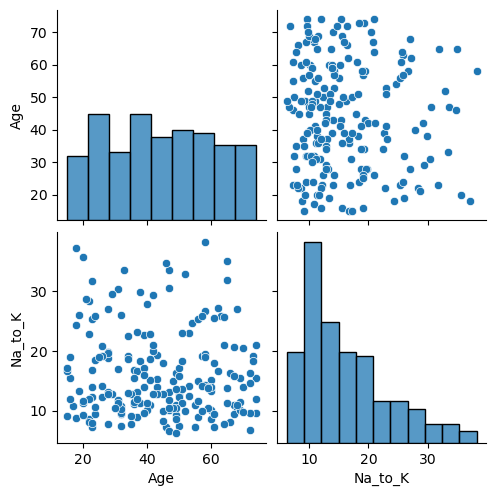

In [23]:
sns.pairplot(df) # Scatter plot for multiple variables
plt.show()

In [24]:
# To see the number of males and females who have high, normal and low BP 
pd.crosstab(index=df["Sex"],columns=df["BP"])

BP,HIGH,LOW,NORMAL
Sex,,,
F,38,28,30
M,39,36,29


In [25]:
# To see the number of males and females who have high,normal cholesterol
pd.crosstab(index=df["Sex"],columns=df["Cholesterol"])

Cholesterol,HIGH,NORMAL
Sex,,
F,49,47
M,54,50


In [26]:
# To see the number of males and females who have high BP,Normal Cholesterol and so on
df.pivot_table(index=["Sex","BP"],columns=["Cholesterol"],aggfunc="count")["Age"]

Cholesterol  HIGH  NORMAL
Sex BP                   
F   HIGH       17      21
    LOW        14      14
    NORMAL     18      12
M   HIGH       18      21
    LOW        17      19
    NORMAL     19      10

### 6.Feature Engineering/Feature Extraction

In [27]:
x_train

,Age,Sex,BP,Cholesterol,Na_to_K
45,66,F,NORMAL,NORMAL,8.107
162,43,M,NORMAL,NORMAL,12.859
62,67,M,LOW,NORMAL,20.693
177,25,M,NORMAL,HIGH,19.011
61,24,M,HIGH,NORMAL,9.475
...,...,...,...,...,...
126,66,M,HIGH,HIGH,16.347
134,42,F,HIGH,HIGH,21.036
188,65,M,HIGH,NORMAL,34.997
26,31,M,HIGH,HIGH,30.366


In [28]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 45 to 167
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Age          160 non-null    int64   
 1   Sex          160 non-null    category
 2   BP           160 non-null    object  
 3   Cholesterol  160 non-null    object  
 4   Na_to_K      160 non-null    float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 6.5+ KB


In [29]:
y_train

45     drugX
162    drugX
62     DrugY
177    DrugY
61     drugA
       ...  
126    DrugY
134    DrugY
188    DrugY
26     DrugY
167    drugX
Name: Drug, Length: 160, dtype: object

In [30]:
# seperating the numerical and categorical columns of xtrain to perfrom transformation


num_data=x_train.select_dtypes(include=["int64","float64"])
ord_data=x_train.select_dtypes(include=["object"])
nom_data=x_train.select_dtypes(include=["category"])

In [31]:
num_data

,Age,Na_to_K
45,66,8.107
162,43,12.859
62,67,20.693
177,25,19.011
61,24,9.475
...,...,...
126,66,16.347
134,42,21.036
188,65,34.997
26,31,30.366


In [32]:
ord_data

,BP,Cholesterol
45,NORMAL,NORMAL
162,NORMAL,NORMAL
62,LOW,NORMAL
177,NORMAL,HIGH
61,HIGH,NORMAL
...,...,...
126,HIGH,HIGH
134,HIGH,HIGH
188,HIGH,NORMAL
26,HIGH,HIGH


In [33]:
nom_data

,Sex
45,F
162,M
62,M
177,M
61,M
...,...
126,M
134,F
188,M
26,M


In [34]:
import scipy.stats as ss

In [35]:
# upon converting features and classes into numerical checking whether my age and Na_to_K follows normal distribution or not

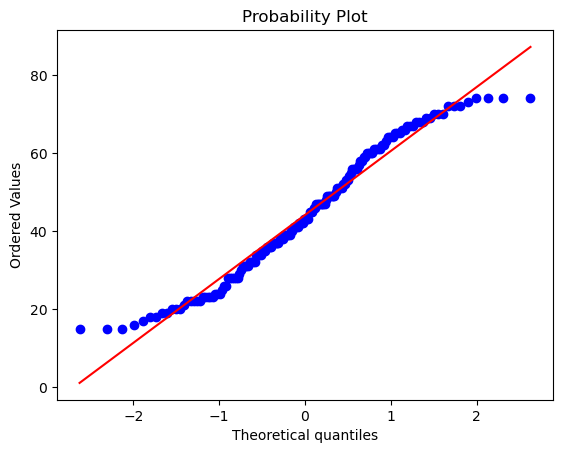

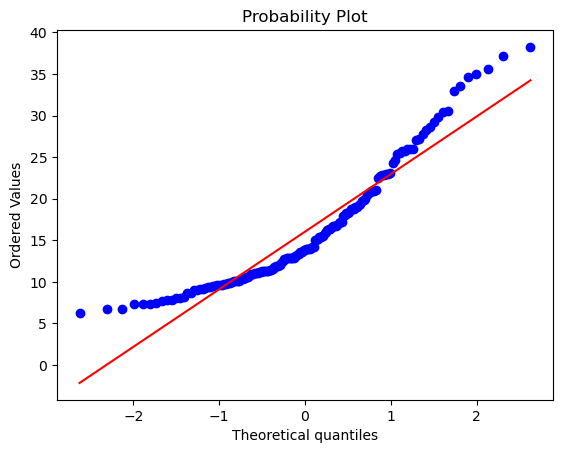

In [36]:
l=["Age","Na_to_K"]
for i in l:
    plt.subplot(111)
    ss.probplot(x_train[i],dist="norm",fit=True,plot=plt)
    plt.show()

### Creating Pipeline

In [37]:
#creating a pipeline for numerical columns for imputing missing values, scaling and powertransformation where they are not following the normal distribution
nup=Pipeline([("input_n",SimpleImputer()),("scaling",StandardScaler()),("power_transformation",PowerTransformer())])

In [38]:
nup

Pipeline(steps=[('input_n', SimpleImputer()), ('scaling', StandardScaler()),
                ('power_transformation', PowerTransformer())])

In [39]:
# pipeline for ordinal data for imputing missing values and ordinal encoder for encoding because it is a ordinal data
op=Pipeline([("imput_c",SimpleImputer(strategy="most_frequent")),("encoding",OrdinalEncoder())])

In [40]:
op

Pipeline(steps=[('imput_c', SimpleImputer(strategy='most_frequent')),
                ('encoding', OrdinalEncoder())])

In [41]:
# pipeline for ordinal data for imputing missing values and onehot encoder for encoding because it is a nominal data
np=Pipeline([("input_nomi",SimpleImputer(strategy="most_frequent")),("encoding_nomi",OneHotEncoder())])

In [42]:
np

Pipeline(steps=[('input_nomi', SimpleImputer(strategy='most_frequent')),
                ('encoding_nomi', OneHotEncoder())])

In [43]:
# creating column transformer using pipeline created
col_tp = ColumnTransformer([
    ("numerical", nup, num_data.columns),
    ("ordinal", op, ord_data.columns),
    ("nominal", np, nom_data.columns)
])

In [44]:
col_tp

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('input_n', SimpleImputer()),
                                                 ('scaling', StandardScaler()),
                                                 ('power_transformation',
                                                  PowerTransformer())]),
                                 Index(['Age', 'Na_to_K'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('imput_c',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OrdinalEncoder())]),
                                 Index(['BP', 'Cholesterol'], dtype='object')),
                                ('nominal',
                                 Pipeline(steps=[('input_nomi',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding_nomi',
                                                  OneHotEncoder())]),
                                 Index(['Sex'], dtype='object'))])

In [45]:
# this is the transformed data to transform the train data by using column transformer pipeline 
fx_train=col_tp.fit_transform(x_train)

In [46]:
col_tp.get_feature_names_out()

array(['numerical__Age', 'numerical__Na_to_K', 'ordinal__BP',
       'ordinal__Cholesterol', 'nominal__Sex_F', 'nominal__Sex_M'],
      dtype=object)

In [47]:
fx_train.shape

(160, 6)

In [48]:
# transforms the test data           
fx_test=col_tp.transform(x_test)

In [49]:
y_le = LabelEncoder()
y_train = y_le.fit_transform(y_train)
y_test = y_le.transform(y_test)

### Model creation

In [50]:
# traing the model and testing 
mix_nb=MixedNB(categorical_features=[2,3,4,5])

In [51]:
model=mix_nb.fit(fx_train,y_train)
predict=model.predict(fx_test)
accuracy_score(y_test,predict)

0.95

In [52]:
predict

array([0, 4, 1, 0, 4, 0, 0, 4, 0, 0, 0, 0, 3, 1, 4, 0, 4, 0, 0, 4, 1, 0,
       0, 4, 1, 4, 0, 0, 0, 0, 2, 1, 0, 3, 0, 4, 4, 3, 2, 0], dtype=int64)

In [53]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      1.00      1.00         5
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3
           4       1.00      0.91      0.95        11

    accuracy                           0.95        40
   macro avg       0.98      0.92      0.94        40
weighted avg       0.96      0.95      0.95        40



### Deployment

In [54]:
# this is the pipeline for preprocessing that can be used in final model 
finalp=Pipeline([("preprocessed",col_tp)])

In [55]:
finalp

Pipeline(steps=[('preprocessed',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('input_n',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   StandardScaler()),
                                                                  ('power_transformation',
                                                                   PowerTransformer())]),
                                                  Index(['Age', 'Na_to_K'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imput_c',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index(['BP', 'Cholesterol'], dtype='object')),
                                                 ('nominal',
                                                  Pipeline(steps=[('input_nomi',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding_nomi',
                                                                   OneHotEncoder())]),
                                                  Index(['Sex'], dtype='object'))]))])

In [56]:
# final mixed naive bayes model for both numerical,categorical data where this can be used for any model 
model=mix_nb.fit(finalp.fit_transform(x_train),y_train)

C:\Users\khang\anaconda3\New folder\lib\site-packages\mixed_naive_bayes\mixed_naive_bayes.py:423: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if categorical_features == 'all':
C:\Users\khang\anaconda3\New folder\lib\site-packages\mixed_naive_bayes\mixed_naive_bayes.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.categorical_features == 'all':


In [57]:
model

MixedNB(alpha=0.5, var_smoothing=1e-09)

### Dumping the model

In [59]:
pickle.dump(finalp,open(r"C:\Users\khang\Elite 14 M-L\ML_Project\Model's\pickle\finalp_drugs.pk1","wb"))
pickle.dump(model,open(r"C:\Users\khang\Elite 14 M-L\ML_Project\Model's\pickle\model_drugs.pk1","wb"))